Simple quick update latest weather

* switched to new sensor 8am BDA 2015-08-21 Old sensor was giving systematic bias and other weirdness.

In [318]:
# Tell matplotlib to plot in line
%matplotlib inline

import datetime

# import pandas
import pandas

# seaborn magically adds a layer of goodness on top of Matplotlib
# mostly this is just changing matplotlib defaults, but it does also
# provide some higher level plotting methods.
import seaborn

# Tell seaborn to set things up
seaborn.set()

def smooth(data, thresh=None):
    """ This smoothing function is meant to spot and eliminate bad readings.
    
    It has some issues ;)
    
    Also, I really need to find out what is causing the bad readings.
    """ 
    
    means = data.mean()

    if thresh is None:
        sds = data.std()
    else:
        sds = thresh
    
    delta = data - data.shift()
    
    good = delta[abs(delta) < sds]

    #print(good.describe())
    
    return delta.where(good, 0.0)


In [319]:
infile = "../files/kittycam_weather.csv"

!scp 192.168.0.128:Adafruit_Python_BMP/weather.csv $infile

weather.csv                                   100% 4289KB   4.2MB/s   00:01    


In [320]:
!wc ../files/weather.csv

  564  1127 56016 ../files/weather.csv


In [321]:
""" assume it is csv and let pandas do magic

  index_col tells it to use the 'date' column in the data
  as the row index, plotting picks up on this and uses the
  date on the x-axis

  The *parse_dates* bit just tells it to try and figure out
  the date/time in the columne labeled 'date'.
"""
data = pandas.read_csv(infile, index_col='date', parse_dates=['date'])

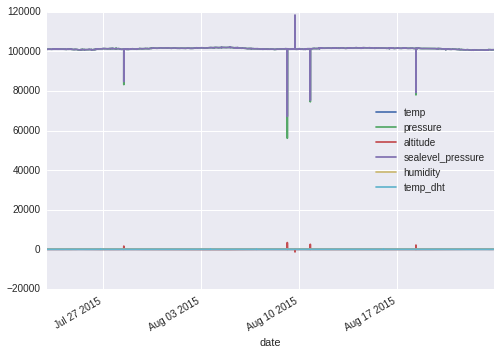

In [322]:
data.plot()

In [323]:
# smooth the data to filter out bad temps and pressures
#data.altitude = (smooth(data.altitude, 5.0).cumsum() + data.altitude[0])
#data.temp = (smooth(data.temp, 5.0).cumsum() + data.temp[0])
data.altitude = data.altitude.clip(-100, 100)

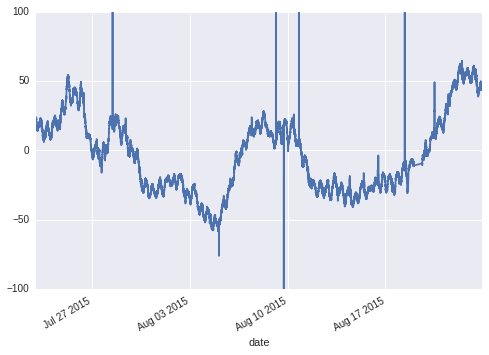

In [324]:
data.altitude.plot()

In [325]:
data.tail()

,temp,pressure,altitude,sealevel_pressure,humidity,temp_dht
date,,,,,,
2015-08-23 22:07:22.638400,28.8,100803,43.382636,100805,70.500000,28.600000
2015-08-23 22:08:23.280674,28.8,100799,43.549842,100800,70.800003,28.600000
2015-08-23 22:09:23.923160,28.7,100799,44.051475,100797,70.699997,28.600000
2015-08-23 22:10:24.565259,28.7,100801,43.800656,100797,70.400002,28.500000
2015-08-23 22:11:27.735676,28.5,100789,43.549842,100801,72.000000,28.299999


In [326]:
data.describe()

,temp,pressure,altitude,sealevel_pressure,humidity,temp_dht
count,44279.000000,44279.000000,44279.000000,44279.000000,44275.000000,44275.000000
mean,28.177486,101362.580862,-3.348267,101364.265882,76.465728,27.807797
std,2.284636,440.099061,27.811352,420.792860,8.796562,2.208862
min,22.800000,56117.000000,-100.000000,67136.000000,29.500000,22.299999
25%,26.500000,101123.000000,-26.690525,101124.000000,71.300003,26.299999
50%,27.700000,101383.000000,-4.910866,101384.000000,76.800003,27.500000
75%,30.000000,101645.000000,16.747636,101646.000000,83.300003,29.400000
max,43.200000,102242.000000,100.000000,118353.000000,94.300003,47.099998


## Dew Point

The warmer air is, the more moisture it can hold.  The *dew point* is
the temperature at which air would be totally saturated if it had as 
much moisture as it currently does. 

Given the temperature and humidity the *dew point* can be calculated, the actual formula is
pretty complex.

It is explained in more detail here: http://iridl.ldeo.columbia.edu/dochelp/QA/Basic/dewpoint.html

>If you are interested in a simpler calculation that gives an approximation of dew point temperature if you know >the observed temperature and relative humidity, the following formula was proposed in a 2005 article by Mark G. >Lawrence in the Bulletin of the American Meteorological Society:

$$Td = T - ((100 - RH)/5.)$$


In [327]:
data['dewpoint'] = data.temp - ((100. - data.humidity)/5.)

### Last 24 hours:

In [328]:
print(datetime.datetime.now())
print(data.ix[-1:])

2015-08-23 19:12:33.895543
                            temp  pressure   altitude  sealevel_pressure  \
date                                                                       
2015-08-23 22:11:27.735676  28.5    100789  43.549842             100801   

                            humidity   temp_dht  dewpoint  
date                                                       
2015-08-23 22:11:27.735676        72  28.299999      22.9  


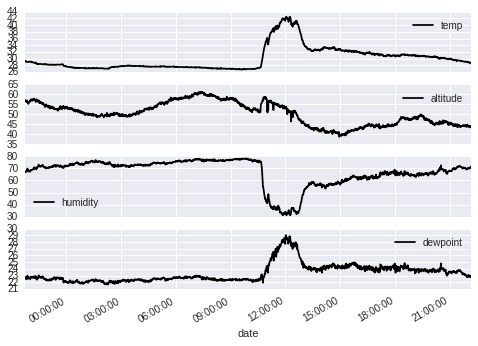

In [329]:
# reading is once a minute, so take last 24 * 60 readings
def plotem(data, n=-60, start=None):
        
    
    if n < 0:
        start = n
        end = len(data)
    else:
        start = start or 0
        end = start + n
        
    data[['temp', 'altitude', 'humidity', 'dewpoint']][start:end].plot(subplots=True)
        
plotem(data, -24*60)

### July 29, 8pm BDA

This plot is interesting, the spike just after 10am (BDA - 3 hours) in temperature, just as there is a drop in pressure.

This coincided with the start of heavy rain.

The noise in the humidity coincides with the rain too.  The increase in humidity around 2pm looks to be at least part (mostly?) due to the temperature dropping.  The dewpoint remained steadier, this is a measure of the amount of moisture in the air.

Now the good news is the pressure looks to be rising a bit.  


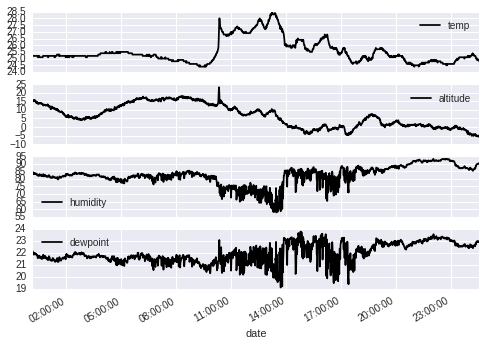

In [330]:
plotem(data,  24 * 60, 8440)

### Last week

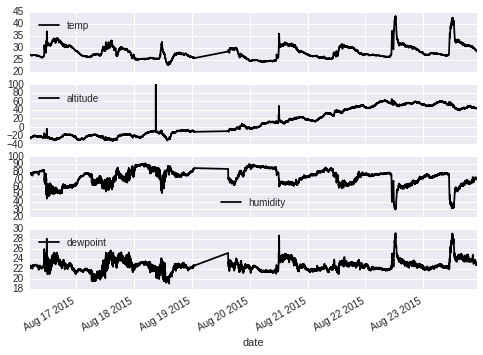

In [331]:
# reading is once a minute, so take last 7 * 24 * 60 readings
plotem(data, -7*24*60)

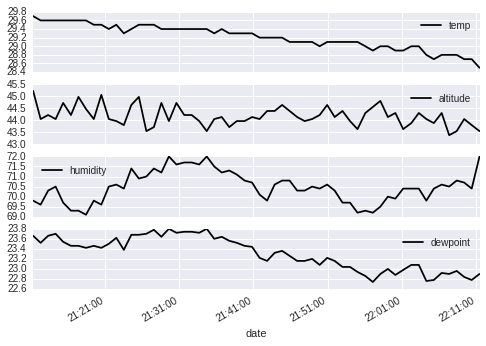

In [332]:
plotem(data)

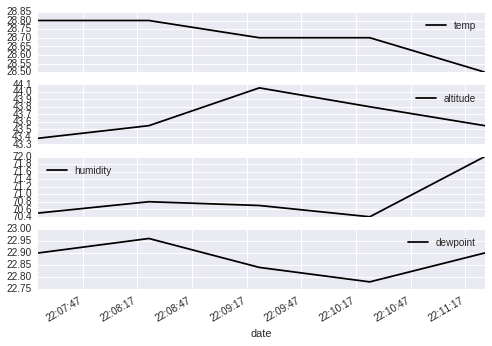

In [333]:
plotem(data, -5)

## Look at all the data

In [334]:
data.describe()

,temp,pressure,altitude,sealevel_pressure,humidity,temp_dht,dewpoint
count,44279.000000,44279.000000,44279.000000,44279.000000,44275.000000,44275.000000,44275.000000
mean,28.177486,101362.580862,-3.348267,101364.265882,76.465728,27.807797,23.470564
std,2.284636,440.099061,27.811352,420.792860,8.796562,2.208862,1.211980
min,22.800000,56117.000000,-100.000000,67136.000000,29.500000,22.299999,16.360000
25%,26.500000,101123.000000,-26.690525,101124.000000,71.300003,26.299999,22.660001
50%,27.700000,101383.000000,-4.910866,101384.000000,76.800003,27.500000,23.480000
75%,30.000000,101645.000000,16.747636,101646.000000,83.300003,29.400000,24.260001
max,43.200000,102242.000000,100.000000,118353.000000,94.300003,47.099998,29.140000


I currently have two temperature sensors:

* DHT22 sensor which gives temperature and humidity.
* BMP180 sensor which gives pressure and temperature.

The plot below shows the two temperature plots.

Both these sensors are currently in my study.  For temperature and humidity I would like to have some readings from outside.  If I can solder them to a phone jack then I can just run phone cable to where they need to be.

**Below** plots the current values from these sensors.  This is handy for calibration.

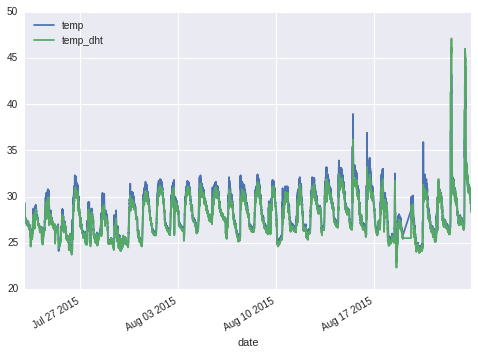

In [335]:
data[['temp', 'temp_dht']].plot()

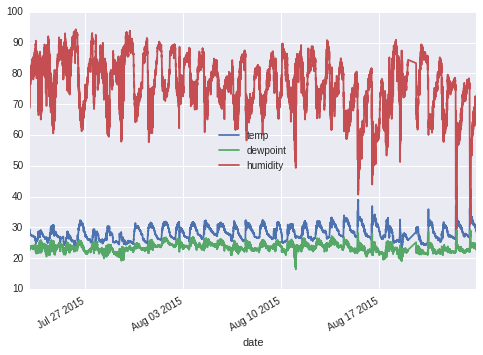

In [336]:
data[['temp', 'dewpoint', 'humidity']].plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8de44af5f8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f8de46d2fd0>], dtype=object)

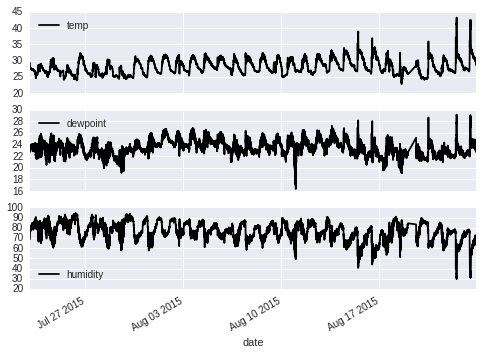

In [337]:
data[['temp', 'dewpoint', 'humidity']].plot(subplots=True)

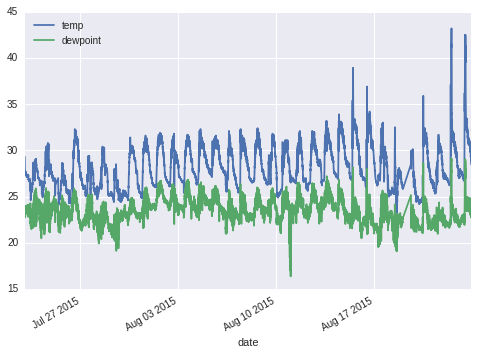

In [338]:
data[['temp', 'dewpoint']].plot()

In [339]:
from numpy import fft

In [340]:
data['fft_altitude'] = fft.fft(data.altitude)
data['fft_alt_real'] = data.fft_altitude.real
data['fft_alt_imag'] = data.fft_altitude.imag


In [341]:
data['alt_power'] = ((data.fft_alt_real ** 2.0) + (data.fft_alt_imag ** 2.0)) ** 0.5

61.49861111111111 61


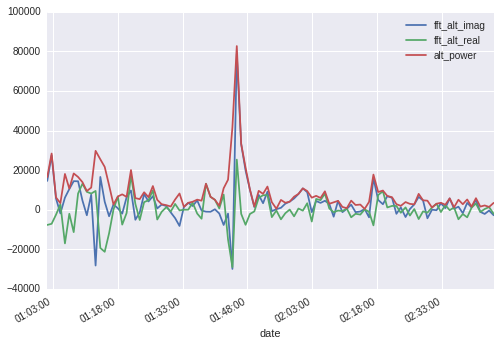

In [342]:
import numpy
N = len(data)
TWELVE = N//(12*60)
print(N/(12*60.), TWELVE)
data['pos'] = numpy.arange(N)
data[['fft_alt_imag', 'fft_alt_real', 'alt_power']][TWELVE//3:2*TWELVE].plot()

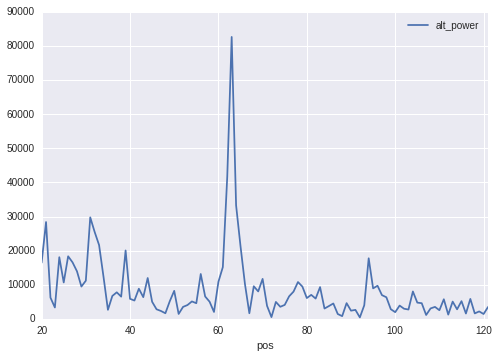

In [343]:
data[TWELVE//3:2*TWELVE].plot(x='pos', y='alt_power')

In [344]:
xx = data.fft_altitude.copy()
xx[TWELVE:-TWELVE] = 0.0
data['smooth_alt'] = [x.real for x in fft.ifft(xx)]

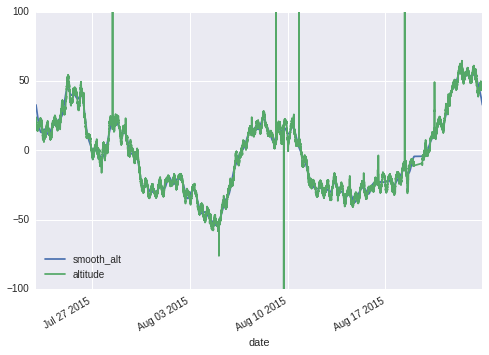

In [345]:
data[['smooth_alt', 'altitude']].plot()

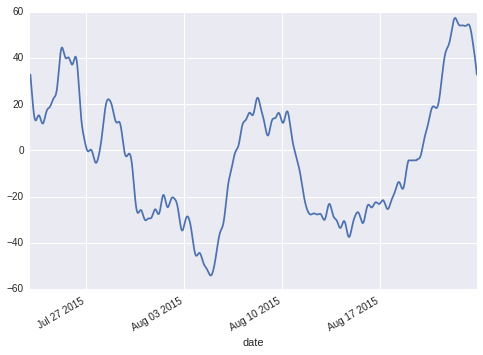

In [346]:
data.smooth_alt.plot()

In [347]:
def power(x, y):
    
    return ((x ** 2.0) + (y ** 2.0)) ** 0.5

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8de594b898>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f8de43e64a8>], dtype=object)

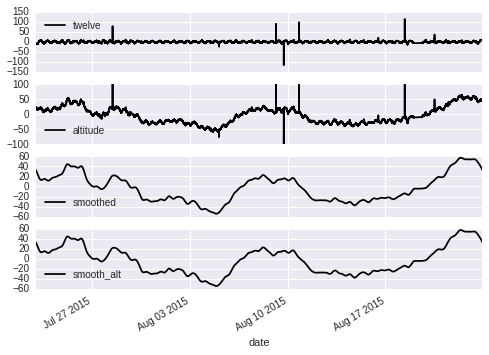

In [348]:
P = TWELVE
xx = data.fft_altitude.copy()
xx[:] = 0.0
xx[P:-P] = data.fft_altitude[P:-P]
data['twelve'] = [x.real for x in fft.ifft(xx)]
data['itwelve'] = [x.imag for x in fft.ifft(xx)]
data['twelve_pow'] = power(data.twelve, data.itwelve)
data['smoothed'] = data.altitude - data.twelve
data[['twelve', 'altitude', 'smoothed', 'smooth_alt']].plot(subplots=True)